In [177]:
!pip install tqdm --user
import matplotlib
matplotlib.use('Agg')
%matplotlib inline


import matplotlib.pyplot as plt

import keras
import numpy as np
import keras.backend
from keras.layers import Activation
from keras import backend as K

  Using cached tqdm-4.15.0-py2.py3-none-any.whl


In [198]:
# model = keras.models.load_model('my_model.h5')


from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
K.set_learning_phase(0)
model = ResNet50(weights='imagenet')

In [9]:
from keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
training_size = 60000

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [184]:
#print(model.layers)
#print(model.layers[0].filters)
from pprint import pprint
#pprint(model.layers[0].get_config())

layer = model.layers[1]

params = model.layers[0].get_weights()
weights = params[0]
biases = params[1]


print("Stride: {}x{}".format(*weights.shape[0:2]))
print("Channels: {}".format(weights.shape[2]))
print("Filters: {}".format(weights.shape[3]))
print("Biases: {}".format(biases.shape[0]))
print("")
print("Params for this layer: {}".format(np.prod(weights.shape) + biases.shape[0]))

IndexError: list index out of range

In [186]:
print("{0: <30} {1: <20} {2: <10}".format("Layer name", "Output shape", "Activation"))
print("{0: <30} {1: <20} {2: <10}".format("==========", "============", "==========\n"))
for layer in model.layers:
    print("{0: <30} {1: <20} {2: <10}".format(layer.output.name, layer.output.shape, getattr(layer, 'activation', '')))

Layer name                     Output shape         Activation
==========                     ============         ==========

input_1:0                      (?, 224, 224, 3)               
conv1/BiasAdd:0                (?, 112, 112, 64)    <function linear at 0x6b45410>
bn_conv1/cond/Merge:0          (?, 112, 112, 64)              
activation_15/Relu:0           (?, 112, 112, 64)    <function relu at 0x6b45230>
max_pooling2d_1/MaxPool:0      (?, 55, 55, 64)                
res2a_branch2a/BiasAdd:0       (?, 55, 55, 64)      <function linear at 0x6b45410>
bn2a_branch2a/cond/Merge:0     (?, 55, 55, 64)                
activation_16/Relu:0           (?, 55, 55, 64)      <function relu at 0x6b45230>
res2a_branch2b/BiasAdd:0       (?, 55, 55, 64)      <function linear at 0x6b45410>
bn2a_branch2b/cond/Merge:0     (?, 55, 55, 64)                
activation_17/Relu:0           (?, 55, 55, 64)      <function relu at 0x6b45230>
res2a_branch2c/BiasAdd:0       (?, 55, 55, 256)     <function line

In [143]:
inputs = [K.learning_phase()] + model.inputs
print(inputs)

[<tf.Tensor 'dropout_9/keras_learning_phase:0' shape=<unknown> dtype=bool>, <tf.Tensor 'conv2d_9_input_1:0' shape=(?, 28, 28, 1) dtype=float32>]


input_1:0                  (?, 224, 224, 3)


ValueError: Cannot feed value of shape (1, 28, 28, 1) for Tensor u'input_1:0', which has shape '(?, 224, 224, 3)'

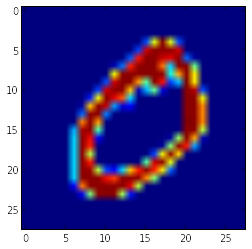

In [195]:
inputs = [K.learning_phase()] + model.inputs


# Set the image we want to visualise activations with
img_to_visualize = [ x_train[1] ]

# Now instead of the image, give it zeroes and see what happens
# img_to_visualize[0] = np.random.rand(28, 28, 1)

plt.imshow(img_to_visualize[0][:, :, 0])

def visualise_filters(layer):
    # Define a Tensorflow function that maps 
    # inputs => outputs
    # which takes into account the difference between training and testing
    # i.e. not using Dropout or Batch Normalization
    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    
    # Squueze removes single-dimensional entries from the shape
    # ie. 1) the training flag, 2) the channel index
    convolutions = np.squeeze(convolutions)
    # print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    # gives the first two values ie. height and width
    size = convolutions.shape[0:2]
    # (26, 26)
    
    fig = plt.figure(figsize=size)
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n, n, i+1)
        ax.imshow(convolutions[:, :, i], cmap='gray')
    plt.show()

def viz(i, viz_func=visualise_filters):
    layer = model.layers[i]
    print("{0: <26} {1: <5}".format(layer.output.name, layer.output.shape))
    viz_func(layer)

# Specify the layer to want to visualize
i = 0

# model.layers[0].activation = Activation('linear')
# model.layers[1].activation = Activation('linear')
for layer in model.layers:
    if i == 1: break
    viz(i)
    i += 1

# viz(0)
# viz(1)
# viz(2)

In [196]:
# model.layers[0].activation = Activation('linear')
# model.layers[1].activation = Activation('linear')
input_img = model.input
print("Input image: {}".format(input_img))

Input image: Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


In [199]:
import tqdm

def viz_loss(layer):
    # we start from a gray image with some noise
    steps = 25
    input_img_data = np.random.random((1, model.input.shape[1], model.input.shape[2], model.input.shape[3])) * steps + 128.
#     size = layer.output.shape[1:3]
    
#     n = int(np.ceil(np.sqrt(layer.output.shape[3])))
    n = 6

    def maximise_filter_activations(filter_index, input_img_data):
        # define a function that maximises activation
        # activation_i = weight_i * input_i
        # mean = sum(activations) / n(activations)
        # thus maximising this mean is akin to maximising the activation
    #     print(K.mean(layer.output[:, :, :, 0])(2))

        activation_strength = K.mean(layer.output[:, :, :, filter_index])
        loss = activation_strength
    #     print(loss)

        # compute the gradient (up/down) of activation wrt the image given
        grads = K.gradients(loss, input_img)[0]
#         print(grads)

        # normalise the gradient
    #     if grads is not None:
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    #     print(grads)

        # function that maps input_img => (activation_strength, gradients)
        # now we adjust input_img to maximise activation
        # we adjust using the gradients (to find the correct direction)
        maximise_activations = K.function([input_img], [loss, grads])

        # run gradient ascent for 20 steps
        # Q: what do we do with the loss_value ?
        step = 1.
    
        loss_value = 0.
        
        for i in range(steps):
            loss_value, grads_value = maximise_activations([input_img_data])
            input_img_data += grads_value * step

        # convert tensor (3+ dimensional matrix) to image
        img = deprocess_image(input_img_data[0])
        img = np.squeeze(img)
        
        return img

    
    size = (26,26)
    fig = plt.figure(figsize=size)
    
    for i in tqdm.trange(32):
        img = maximise_filter_activations(i, input_img_data)
        ax = fig.add_subplot(n, n, i+1)
        ax.imshow(img, cmap='gray')
    plt.show()
    

    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB spectrum
    x *= 255
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

viz(2, viz_func=viz_loss)


  0%|          | 0/32 [00:00<?, ?it/s]

bn_conv1_1/batchnorm_1/add_1:0 (?, 112, 112, 64)


ValueError: None values not supported.

  0%|          | 0/32 [00:00<?, ?it/s]

conv2d_10_1/Relu:0         (?, 24, 24, 64)


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


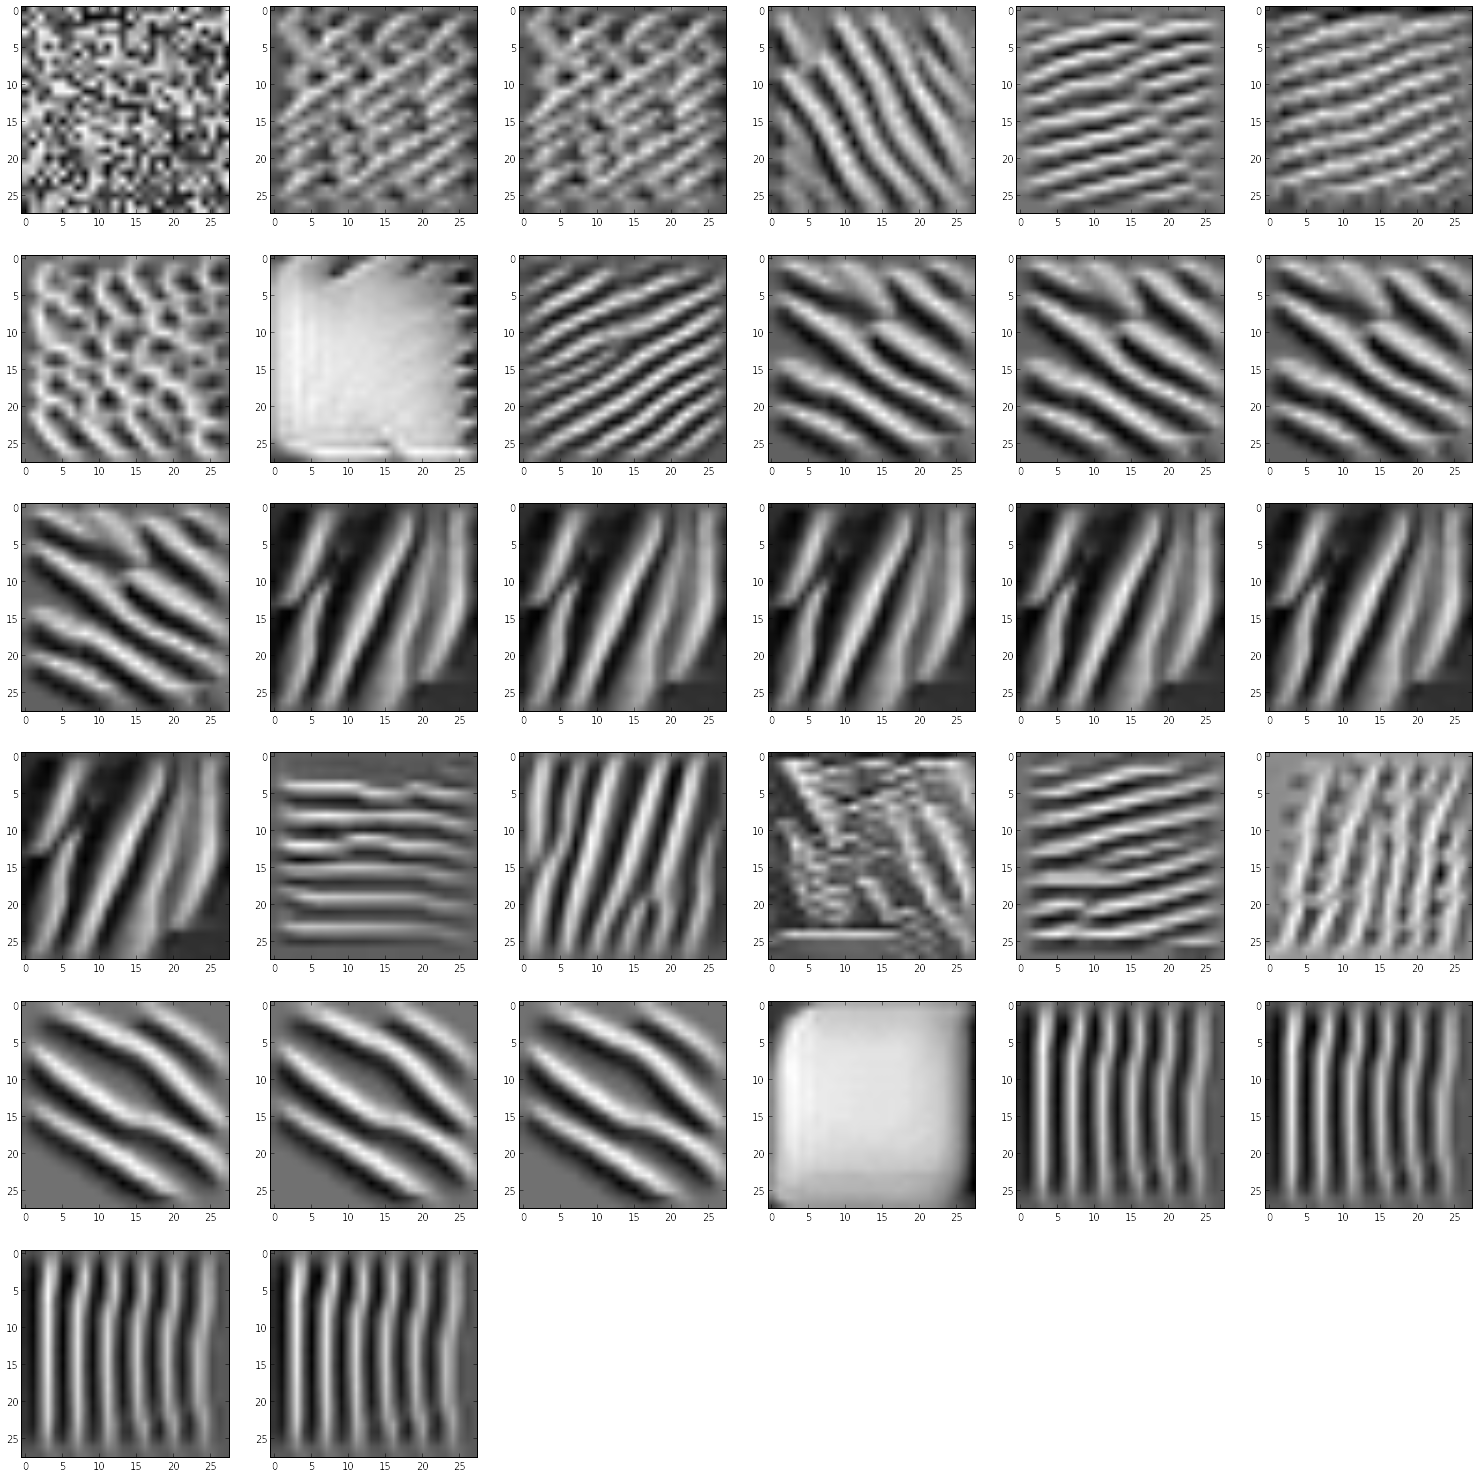

In [180]:
viz(1, viz_func=viz_loss)

  0%|          | 0/32 [00:00<?, ?it/s]

max_pooling2d_5_1/MaxPool:0 (?, 12, 12, 64)


100%|██████████| 32/32 [00:19<00:00,  1.59it/s]


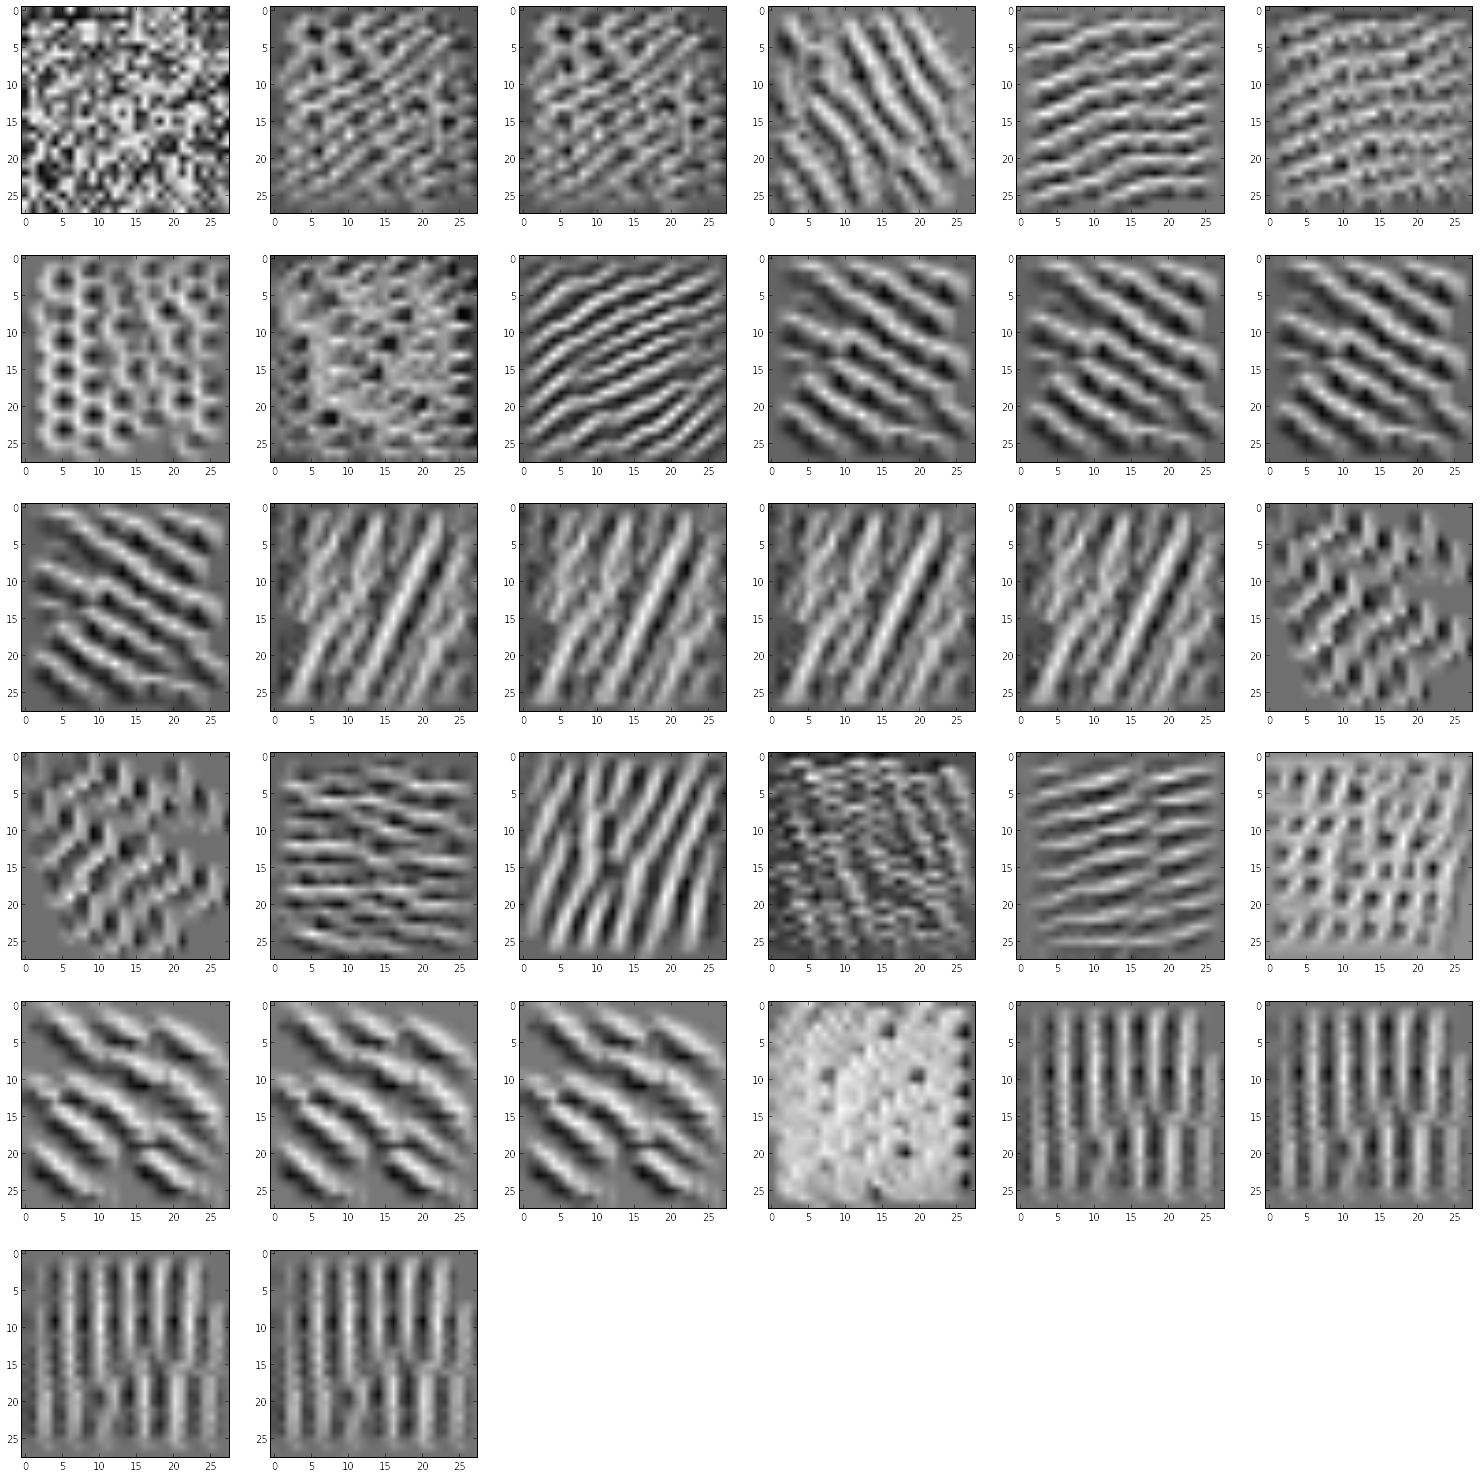

In [181]:
viz(2, viz_func=viz_loss)

  0%|          | 0/32 [00:00<?, ?it/s]

dropout_9_1/cond/Merge:0   (?, 12, 12, 64)


InvalidArgumentError: You must feed a value for placeholder tensor 'dropout_9/keras_learning_phase' with dtype bool
	 [[Node: dropout_9/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_conv2d_9_input_1_0/_6192 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_173__recv_conv2d_9_input_1_0", _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_conv2d_9_input_1_0)]]

Caused by op u'dropout_9/keras_learning_phase', defined at:
  File "/usr/lib64/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lzedward/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/home/lzedward/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lzedward/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lzedward/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lzedward/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/lzedward/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-031dd5c9328c>", line 1, in <module>
    model = keras.models.load_model('my_model.h5')
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/models.py", line 1214, in from_config
    model.add(layer)
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/models.py", line 475, in add
    output_tensor = layer(self.outputs[0])
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/layers/core.py", line 111, in call
    training=training)
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2610, in in_train_phase
    training = learning_phase()
  File "/home/lzedward/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 115, in learning_phase
    name='keras_learning_phase')
  File "/home/lzedward/.local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1520, in placeholder
    name=name)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/lzedward/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dropout_9/keras_learning_phase' with dtype bool
	 [[Node: dropout_9/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_conv2d_9_input_1_0/_6192 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_173__recv_conv2d_9_input_1_0", _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_conv2d_9_input_1_0)]]
